In [1]:
from fastai.vision.all import *

# MNIST dataset

In this notebook I'll try to give a bit of the background of the core ideas of computer vision and neural nets. The cornerstone dataset (and associated problem) is MNIST dataset of hand-written digits and ability to recognize them using computers. Convienently, FASTAI has this dataset too.

In [2]:
path_mnist = untar_data(URLs.MNIST)

In [3]:
items = get_image_files(path_mnist)
items[:3]

(#3) [Path('/home/jan/.fastai/data/mnist_png/testing/8/1583.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/7776.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/7545.png')]

<AxesSubplot:>

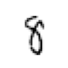

In [4]:
sample_image = PILImageBW.create(items[0])
sample_image.show()

From paths, one can see that the dataset is organized in the following way `subset\class\image_name` so `GrandparentSplitter` can bve used to form train and test sets

In [5]:
splitter = GrandparentSplitter(train_name='training', valid_name='testing')

In [6]:
splits = splitter(items)

I can look at training and validation items indeces now

In [7]:
#Train,Val
splits[0][:3],splits[1][:3]

([10000, 10001, 10002], [0, 1, 2])

In [8]:
get_image_files(path_mnist / 'testing')

(#10000) [Path('/home/jan/.fastai/data/mnist_png/testing/8/1583.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/7776.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/7545.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/7694.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/8266.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/8405.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/4807.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/5163.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/1912.png'),Path('/home/jan/.fastai/data/mnist_png/testing/8/6958.png')...]

The indexation of training set starts at 10000, suggesting first 10000 items are testing items, which indeed is correct looking at the number of iamges in the `testing` subfolder

Now, I'll create dataset(s) from those splits

In [9]:
mnist_datasets = Datasets(items, tfms=[[PILImageBW.create], [parent_label,Categorize]], splits=splits)

Breaking it into parts, Datasets ingests:
* List of items (lsit of image paths in this  case)
* List of 2 lists of transforms used to obtain x (input) and y (output) from the item, here x is loading an image stored in the image path and y gets the label from the parent folder and then maps those labels to category indeces
* train/val splits

One can look at the item in the `Dataset`

<AxesSubplot:title={'center':'8'}>

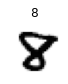

In [10]:
show_at(mnist_datasets.train,0)

According to the splitter, the training item at index 0 should be the item index 10000 in the whole set, which indeed is the case

<AxesSubplot:>

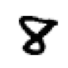

In [11]:
sample_image = PILImageBW.create(items[10000])
sample_image.show()

Now to be able to work on the dataset with classifier, I need to make sure those images are tensors, of the same size and can probably introduce some augemntation in the form of random crops too. There are too transformation types in FAST AI, `item transforms` which are applied at each individual item and run on CPU and `batch transforms` applied in the same way to the whole batch and done on GPU.

In [12]:
item_tfms = [ToTensor(), CropPad(size=36, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

In [13]:
batch_tfms = [IntToFloatTensor(), Normalize()]

Now the dataloaders can be built from datasets using those transforms.

In [14]:
mnist_dataloaders = mnist_datasets.dataloaders(bs=256, after_item=item_tfms, after_batch=batch_tfms)

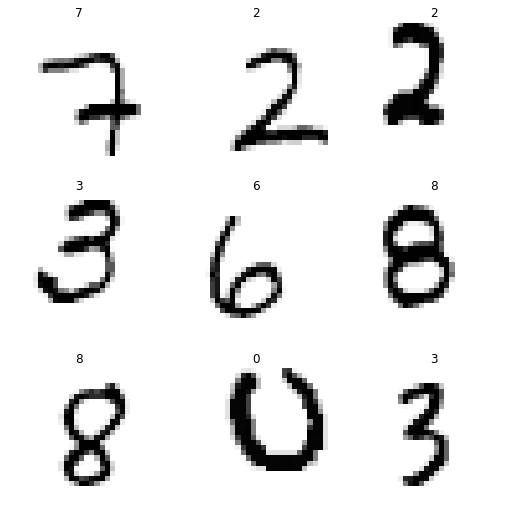

In [15]:
mnist_dataloaders.show_batch()

I can also look at the sizes of the single batch

In [16]:
xb,yb = mnist_dataloaders.one_batch()
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

As expected, input batch has shape of [N,C,H,W] where N is number of the items in the batch, C=1 is number of channels (grayscale image has a single channel  information) and H,W being image height and width respectively. output batch has a shape of N, since the otput of the prediction is a single class label for each image in the batch. I can also check that there are 10 classes in total as expected

In [17]:
mnist_dataloaders.c

10

## Building the neural net

### Very simplified history

The first iterations of neural nets (perceptrons) consited only of so called fully connected layers. Such layer takes all the elements of the input and predefined number of output elements (neurons) and connects every pair of them together by a scaling factor (weight). Each output neuron can have some bias term as well (additional constant that we add to its output, no matter what the input was). Mathematically it can be seen as $ Output = W*input+b $ where $ W $ is the matrix of weights, and $ b, input, output $ are vectors. There is an excellent video and article by Grant Sanderson [here](https://www.3blue1brown.com/lessons/neural-networks) explaining it in more detail.

When Machine Learning evolved and moved to image analysis, it turned out that the fully connected layers are too heavy (have too many parameters) and don't grasp the 2D (or 3D for one color images) structure of information. In order to address those issues,  convolution layers were introduced. Such layer is built from a number of kernels (filters) which can be imagined as a small window of weights sliding over the image. The idea was borrowed from classical image analysis techiques, where such kernels were used for example for edge detection (see for example [Sobel Filter](https://en.wikipedia.org/wiki/Sobel_operator)). A collection of such kernels has several advantages:
* A lot less parameters than fully connected layer for large input sizes
* Ability to encode the spatial information of groups of local pixels (feature maps)
* For networks built entirely of convolutional layers, you don't require predefined input size

Convolutional layers have a lot of parameters describing their behaviour (size, how they slide over the image, number of kernels in the layer etc)  - there is an excellent description of those [here](https://arxiv.org/pdf/1603.07285.pdf)

Both the fully connected layers and convolution layers are linear transformations (addition and multiplication). In order for model to be able to learn non-linear behaviour, additional non-linear function must be introduced (called activation function). The most commonly used one is Rectified Linear Unit (ReLU), which returns x for x>0 and 0 for x <= 0. There is [a lot more](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/) of activation functions to choose from, but for this demonstration ReLu is enough.

Final block of the network is a 'helper' batch normalization layer. It helps to keep gradients under control during the training and as a result leads to faster model convergence. If you want to understand how the model learns during training, Grant has another great video on the subject [here](https://www.3blue1brown.com/lessons/gradient-descent).

### Building blocks

In [18]:
#3x3 kernels moving every 2 pixels with ni input channels, nf output channels and no bias
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1, bias=False) 

In [19]:
def bn(nf): return nn.BatchNorm2d(nf)

In [20]:
def ReLU(): return nn.ReLU(inplace=False)

I'll use the `nn.Sequential` module from PyTorch, which essentially creates a single line of layers stacked one after another with output of the preceding layer being input to the next one. Note that the convolution layers change the number of channels and batchnorm does not, but the dimensions of connected layers are well matched

In [21]:
model = nn.Sequential(
    conv(1, 8),
    bn(8),
    ReLU(),
    conv(8, 16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32, 16),
    bn(16),
    ReLU(),
    conv(16, 10),
    bn(10),
    Flatten()
)

The final `Flatten` function collapses additional dimensions from the last layer into a single dimension vector with score for each number

Upon building a learner with that model, the actual full dimensions of the layers can be seen

In [22]:
learn = Learner(mnist_dataloaders, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [23]:
learn.summary()

Sequential (Input shape: 256)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 8 x 14 x 14   
Conv2d                                    72         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 16 x 7 x 7    
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 32 x 4 x 4    
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
__________________________________________________

As expected, convolution layers have 3 x 3 x ni x nf parameters and batchnorm layers 2 x nf.
It can be trained now:

SuggestedLRs(valley=0.010964781977236271)

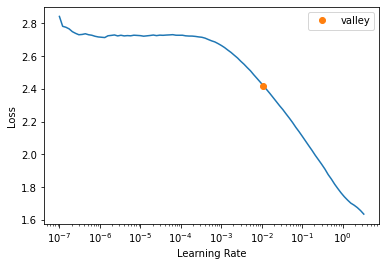

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.277194,0.214870,0.931700,00:09
1,0.159472,0.127545,0.958900,00:08
2,0.124581,0.106111,0.964500,00:09
3,0.082404,0.060451,0.980000,00:08
4,0.058302,0.040417,0.986400,00:08


Fast AI has a `ConvLayer` function that encompasses the 3 basic building blocks (`Conv2d`,`BatchNorm` and `ReLU`) in a single block, that makes building the model a lot simpler.

In [26]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

As can be seen below, the elements inside are the same as in earlier model block

In [27]:
conv2(1,8)

ConvLayer(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

Building the whole model again

In [28]:
model2 = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

Model summary looks the same

In [29]:
learn2 = Learner(mnist_dataloaders, model2, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [30]:
learn2.summary()

Sequential (Input shape: 256)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 8 x 14 x 14   
Conv2d                                    72         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 16 x 7 x 7    
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 32 x 4 x 4    
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
__________________________________________________

Training

In [31]:
learn2.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.304594,0.198278,0.938100,00:08
1,0.165254,0.235480,0.924300,00:08
2,0.122354,0.100670,0.966600,00:08
3,0.085143,0.053598,0.983700,00:08
4,0.058952,0.039836,0.987400,00:08


## Poor mans ResNet

ResNet is one of the more widespread and successful neural network architectures ([paper](https://arxiv.org/pdf/1512.03385.pdf)). The name comes from residual layers (blocks) that accept the feature map and return the same size feature map which is sum of the pure input and input passed through 2 convolutional filters. Let's build such block below:

In [32]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf)
        self.conv2 = ConvLayer(nf, nf)
  
    def forward(self, x): return x + self.conv2(self.conv1(x))

Let's stick those ResBlocks between the layers of the previous model

In [33]:
model3 = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [34]:
model3

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

Since almost all `conv2` blocks are followed `ResBlock`, the netowrk structure can be simplified further:

In [35]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [36]:
model4 = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

There are more `Sequential` wrappers, but the model is essentially the same

In [37]:
model4

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ResBlock(
      (conv1): ConvLayer(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): ConvLayer(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (1): Sequential(
    (0): ConvLayer(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1)

In [38]:
learn3 = Learner(mnist_dataloaders, model4, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.019054606556892395)

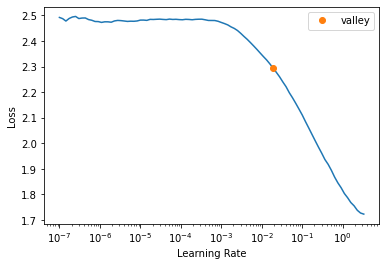

In [39]:
learn3.lr_find()

In [40]:
learn3.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.215138,0.226018,0.929300,00:09
1,0.106958,0.113561,0.964200,00:09
2,0.074130,0.118930,0.962900,00:09
3,0.050473,0.036024,0.988700,00:09
4,0.031352,0.023435,0.992300,00:09


Over 99%, not bad